# Bagging and Random Forest Models

Using **ensemble methods** can greatly improve the results achieved with weak machine learning algorithms, also called **weak learners**. Ensemble methods achieve better performance by aggregating the results of many statistically independent models. This process averages out the errors and produces a final better prediction. 

In this lab you will work with a widely used ensemble method known as **bootstrap aggregating** or simply **bagging**. Bagging follows a simple procedure:
1. N learners (machine learning models) are defined. 
2. N subsamples of the training data are created by **Bernoulli sampling with replacement**.
3. The N learners are trained on the subsamples of the training data.
4. The ensemble is scored by averaging, or taking a majority vote, of the predictions from the N learners.

**Classification and regression tree models** are most typically used with bagging methods. The most common such algorithm is know as the **random forest**. The random forest method is highly scalable and generally produces good results, even for complex problems. 

Classification and regression trees tend to be robust to noise or outliers in the training data. This is true for the random forest algorithm as well. 

## Example: Iris dataset

As a first example you will use random forest to classify the species of iris flowers. 

As a first step, execute the code in the cell below to load the required packages to run the rest of this notebook. 

In [11]:
## Import packages
library(ggplot2)
library(gridExtra)
library(repr)
library(dplyr)
library(caret)
library(randomForest)
library(ROCR)

options(repr.plot.width=4, repr.plot.height=4) # Set the initial plot area dimensions

The code in the cell below displays the head of the data frame and plots all pairwise combinations of the features with the species of the iris flower in colors. Execute this code and examine the results. 

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa
4.9,3.1,1.5,0.1,setosa


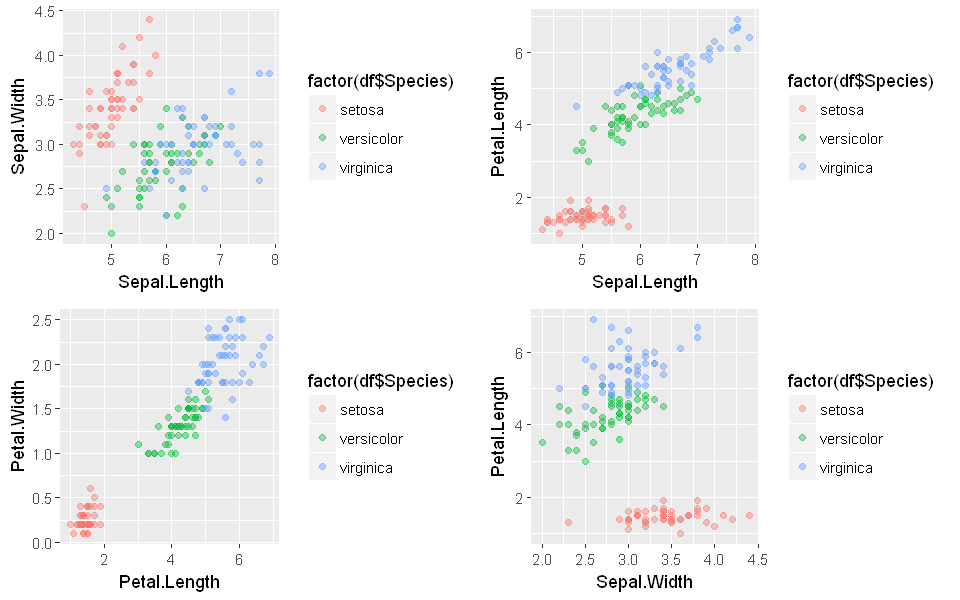

In [12]:
single_plot = function(df, colx, coly){
    ggplot(df, aes_string(colx,coly)) +
          geom_point(aes(color = factor(df$Species)), alpha = 0.4)
}

plot_iris = function(df){
    options(repr.plot.width=8, repr.plot.height=5)
    grid.arrange(
        single_plot(df, 'Sepal.Length', 'Sepal.Width'),
        single_plot(df, 'Sepal.Length', 'Petal.Length'),
        single_plot(df, 'Petal.Length', 'Petal.Width'),
        single_plot(df, 'Sepal.Width', 'Petal.Length'),
        nrow = 2)
}

head(iris, 10)   
plot_iris(iris)

You can see that Setosa (in blue) is well separated from the other two categories. The Versicolor (in orange) and the Virginica (in green) show considerable overlap. The question is how well our classifier will separate these categories. 

Next, execute the code in the cell below to split the dataset into test and training set. Notice that unusually, 67% of the cases are being used as the test dataset. 

In [13]:
set.seed(1955)
## Randomly sample cases to create independent training and test data
partition = createDataPartition(iris[,'Species'], times = 1, p = 0.33, list = FALSE)
training = iris[partition,] # Create the training sample
dim(training)
test = iris[-partition,] # Create the test sample
dim(test)

[1] 51  5

[1] 99  5

As is always the case with machine learning, numeric features  must be scaled. Execute the code in the cell below to scale the training and test datasets:

In [14]:
num_cols = c('Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width')
preProcValues <- preProcess(training[,num_cols], method = c("center", "scale"))

training[,num_cols] = predict(preProcValues, training[,num_cols])
test[,num_cols] = predict(preProcValues, test[,num_cols])
head(training[,num_cols])

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
3,-1.2646501,0.4563512,-1.348274,-1.287390
5,-0.9016267,1.4161001,-1.293220,-1.287390
6,-0.4175955,2.1359118,-1.128059,-1.027876
9,-1.6276734,-0.2634605,-1.293220,-1.287390
10,-1.0226345,0.2164140,-1.238167,-1.417146
11,-0.4175955,1.6560373,-1.238167,-1.287390


Now you will define and fit a random forest model. The code in the cell below defines random forest model with 5 trees using the `randomForest` function from the R randomForest package, and then fits the model. Execute this code.

In [15]:
set.seed(1115)
rf_mod = randomForest(Species ~ ., data = training, ntrees = 5)

Next, the code in the cell below uses the `predict` method is used to compute the class score from the scaled features. Execute this code. 

In [16]:
test$scores = predict(rf_mod, newdata = test)
head(iris, 20)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa
4.9,3.1,1.5,0.1,setosa


It is time to evaluate the model results. Keep in mind that the problem has been made difficult deliberately, by having more test cases than training cases. 

The iris data has three species categories. Therefore it is necessary to use evaluation code for a three category problem. The function in the cell below extends code from pervious labs to deal with a three category problem. Execute this code and examine the results.

In [17]:
print_metrics = function(df, label){
    ## Compute and print the confusion matrix
    cm = as.matrix(table(Actual = df$Species, Predicted = df$scores))
    print(cm)

    ## Compute and print accuracy 
    accuracy = round(sum(sapply(1:nrow(cm), function(i) cm[i,i]))/sum(cm), 3)
    cat('\n')
    cat(paste('Accuracy = ', as.character(accuracy)), '\n \n')                           

    ## Compute and print precision, recall and F1
    precision = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[i,]))
    recall = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[,i]))    
    F1 = sapply(1:nrow(cm), function(i) 2*(recall[i] * precision[i])/(recall[i] + precision[i]))    
    metrics = sapply(c(precision, recall, F1), round, 3)        
    metrics = t(matrix(metrics, nrow = nrow(cm), ncol = ncol(cm)))       
    dimnames(metrics) = list(c('Precision', 'Recall', 'F1'), unique(test$Species))      
    print(metrics)
}  
print_metrics(test, 'Species')

            Predicted
Actual       setosa versicolor virginica
  setosa         33          0         0
  versicolor      0         31         2
  virginica       0          3        30

Accuracy =  0.949 
 
          setosa versicolor virginica
Precision      1      0.939     0.909
Recall         1      0.912     0.938
F1             1      0.925     0.923


Examine these results. Notice the following:
1. The confusion matrix has dimension 3X3. You can see that most cases are correctly classified with only a few errors. 
2. The overall accuracy is 0.94. Since the classes are roughly balanced, this metric indicates relatively good performance of the classifier, particularly since it was only trained on 50 cases. 
3. The precision, recall and  F1 for each of the classes is quite good.
|
To get a better feel for what the classifier is doing, the code in the cell below displays a set of plots showing correctly (as '+') and incorrectly (as 'o') cases, with the species color-coded. Execute this code and examine the results. 

Examine these plots. You can see how the classifier has divided the feature space between the classes. Notice that most of the errors occur in the overlap region between Virginica and Versicolor. This behavior is to be expected.  

Is it possible that a random forest model with more trees would separate these cases better? The code in the cell below uses a model with 40 trees (estimators). This model is fit with the training data and displays the evaluation of the model. 

Execute this code and answer **Question 1** on the course page.

In [18]:
set.seed(1115)
rf_mod = randomForest(Species ~ ., data = training, ntrees = 100)
test$scores = predict(rf_mod, newdata = test)
print_metrics(test, 'Species')

            Predicted
Actual       setosa versicolor virginica
  setosa         33          0         0
  versicolor      0         31         2
  virginica       0          3        30

Accuracy =  0.949 
 
          setosa versicolor virginica
Precision      1      0.939     0.909
Recall         1      0.912     0.938
F1             1      0.925     0.923


These results are identical to the model with 5 trees. 

Like most tree-based models, random forest models have a nice property that **feature importance** is computed during model training. Feature importance can be used as a feature selection method. The `varImp` function from the Caret package performs the calculation.  

Execute the code in the cell below to display a plot of the feature importance.

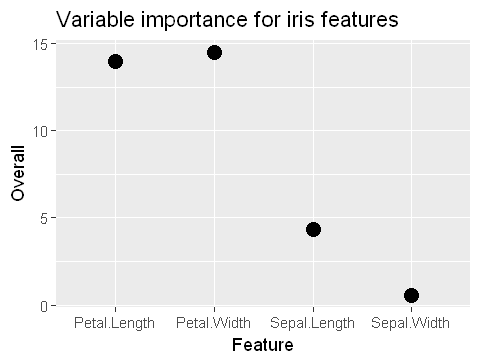

In [19]:
options(repr.plot.width=4, repr.plot.height=3)
imp = varImp(rf_mod)
imp[,'Feature'] = row.names(imp)
ggplot(imp, aes(x = Feature, y = Overall)) + geom_point(size = 4) +
       ggtitle('Variable importance for iris features')

Examine the plot displayed above. Notice that the Speal_Lenght and Sepal_Width have rather low importance. 

Should these features be dropped from the model? To find out, you will create a model with a reduced feature set and compare the results. As a first step, execute the code in the cell below to create training and test datasets using the reduced features.

In [20]:
set.seed(1115)
rf_mod = randomForest(Species ~ Petal.Length + Petal.Width, data = training, ntrees = 100)
test$scores = predict(rf_mod, newdata = test)
print_metrics(test, 'Species')

            Predicted
Actual       setosa versicolor virginica
  setosa         33          0         0
  versicolor      0         32         1
  virginica       0          3        30

Accuracy =  0.96 
 
          setosa versicolor virginica
Precision      1      0.970     0.909
Recall         1      0.914     0.968
F1             1      0.941     0.937


Once you have executed the code, answer **Question 2** on the course page.

These results are a bit better which may indicate the original model was overfit. Given that a simpler model is more likely to generalize, this model is preferred. 

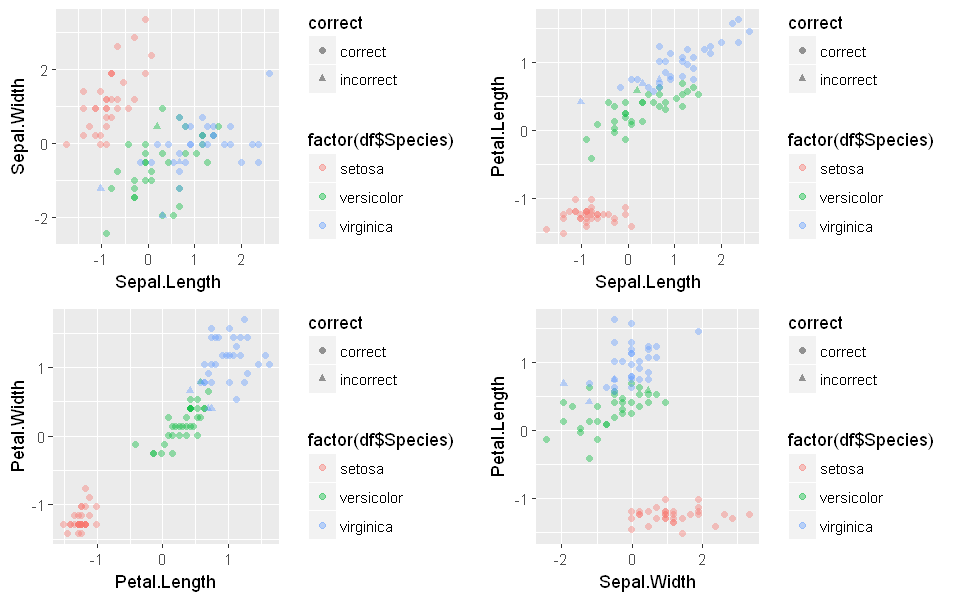

In [21]:
## Create column of correct-incorrect classification
test$correct = ifelse(test$Species == test$scores, 'correct', 'incorrect')

single_plot_classes = function(df, colx, coly){
    ggplot(df, aes_string(colx,coly)) +
          geom_point(aes(color = factor(df$Species), shape = correct), alpha = 0.4)
}

plot_iris_classes = function(df){
    options(repr.plot.width=8, repr.plot.height=5)
    grid.arrange(
        single_plot_classes(df, 'Sepal.Length', 'Sepal.Width'),
        single_plot_classes(df, 'Sepal.Length', 'Petal.Length'),
        single_plot_classes(df, 'Petal.Length', 'Petal.Width'),
        single_plot_classes(df, 'Sepal.Width', 'Petal.Length'),
        nrow = 2)
}

plot_iris_classes(test)

## Another example


Now, you will try a more complex example using the credit scoring data. You will use the prepared data which has been prepared by removing duplicate cases. Some columns which are know not to be predictive are removed. Execute the code in the cell below to load the dataset for the example. 

In [3]:
credit = read.csv('German_Credit_Preped.csv', header = TRUE)
## Subset the data frame
credit = credit[,c('checking_account_status', 'loan_duration_mo', 'credit_history', 'loan_amount', 'savings_account_balance',
                   'time_employed_yrs', 'payment_pcnt_income', 'time_in_residence', 'property', 'age_yrs',
                   'other_credit_outstanding', 'number_loans', 'job_category', 'dependents', 'telephone', 'bad_credit' )]
print(dim(credit))
names(credit)

[1] 999  16


[1] "checking_account_status"  "loan_duration_mo"        
 [3] "credit_history"           "loan_amount"             
 [5] "savings_account_balance"  "time_employed_yrs"       
 [7] "payment_pcnt_income"      "time_in_residence"       
 [9] "property"                 "age_yrs"                 
[11] "other_credit_outstanding" "number_loans"            
[13] "job_category"             "dependents"              
[15] "telephone"                "bad_credit"

Cross validation will be used to train the model. Since folds will be selected from the entire dataset the numeric features are scaled in batch. Execute the code in the cell below to accomplish this: 

In [6]:
num_cols = c('loan_duration_mo', 'loan_amount', 'payment_pcnt_income',
             'time_in_residence', 'age_yrs', 'number_loans', 'dependents')

preProcValues <- preProcess(credit[,num_cols], method = c("center", "scale"))
credit[,num_cols] = predict(preProcValues, credit[,num_cols])
head(credit[,num_cols])

loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents
2.2464282,0.9483849,-0.86876113,-0.7645835,-1.19202026,-0.7035652,-0.4283287
-0.7397312,-0.4170067,-0.86876113,0.1414888,1.18945982,-0.7035652,2.3323187
1.7487350,1.6323204,-0.86876113,1.0475610,0.83664795,-0.7035652,2.3323187
0.2556552,0.5655086,0.02505181,1.0475610,1.54227168,1.0276211,2.3323187
1.2510417,2.0477820,-0.86876113,1.0475610,-0.04538171,-0.7035652,2.3323187
0.2556552,-0.1552623,0.02505181,1.0475610,1.54227168,-0.7035652,-0.4283287


The code in the cell below uses the capability of the R Caret package to estimate the best hyperparameters using 10 fold cross validation with 5 repeats. There are a few points to note here:
1. Since there is significant class imbalance, recall is used as the metric to optimize. A function, `recallSummary` is used to define this metric. This function is specified in the `trainControl` object.
2. The model is trained using all features as can be seen from the model formula in the Caret `train` function. 
3. The recall metric is specified as a `metric` in the call to `train`. 
4. Weights are specified to help with the class imbalance. 
5. he `train` function automatically generates and searches a hyperparameter grid and prints the metrics. 

Execute this code, examine the result, and answer **Question 3** on the course page.

In [7]:
recallSummary = function (data, lev = NULL, model = NULL) {
                    out = recall(data$obs, data$pred)  
                    names(out) <- "recall"
                    out
}

fitControl = trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 5,
                           summaryFunction = recallSummary)

set.seed(3344)
rf_fit <- train(factor(bad_credit) ~ ., # make label a factor since classification model
                 data = credit, 
                 metric = "recall", 
                 method = "rf", # Random forest model
                 trControl = fitControl,
                 weight = c(0.9,0.1),
                 verbose = FALSE)
rf_fit

Random Forest 

999 samples
 15 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 899, 899, 899, 899, 899, 899, ... 
Resampling results across tuning parameters:

  mtry  recall   
   2    0.7273570
  16    0.7912464
  31    0.7926804

recall was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 31.

The grid of hyperpameters searched by the Caret package is only `mtry`. The grid along with the recall metric is shown in the printed table. 

Given the optimal hyperparameters, which features are the most important? The code in the cell below computes and displays feature importance using the Caret `varImp` function. Execute this code and examine the results. 

rf variable importance

  only 20 most important variables shown (out of 31)

                                                      Overall
loan_amount                                           100.000
age_yrs                                                65.913
loan_duration_mo                                       59.060
checking_account_statusnone                            52.542
time_in_residence                                      22.751
payment_pcnt_income                                    20.011
other_credit_outstandingnone                           11.569
savings_account_balanceunknown/none                    10.959
credit_historycritical account - other non-bank loans   8.020
time_employed_yrsunemployed                             7.848
checking_account_status0 - 200 DM                       7.802
propertyreal estate                                     7.795
propertycar or other                                    7.770
propertyunknown-none                                  

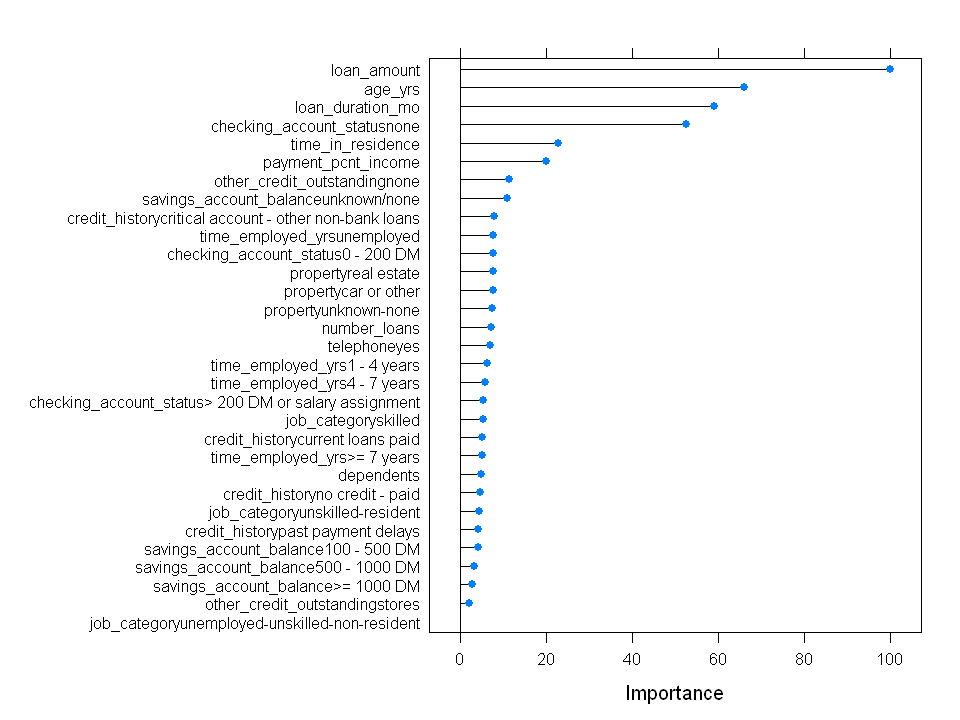

In [30]:
options(repr.plot.width=8, repr.plot.height=6)
var_imp = varImp(rf_fit)
print(var_imp)
plot(var_imp)

In is clear that some of the features are not important to model performance. Execute the code in the cell below to prune the feature set:

In [42]:
credit_reduced = credit[,c('loan_amount', 'age_yrs', 'loan_duration_mo', 'checking_account_status', 'time_in_residence',
                          'payment_pcnt_income', 'other_credit_outstanding', 
                          'credit_history', 'time_employed_yrs', 'property', 'number_loans', 'telephone',
                          'bad_credit')]

Execute the code in the cell below to perform the cross validation grid search using the reduced feature set: 

In [43]:
set.seed(3344)
rf_fit <- train(factor(bad_credit) ~ ., # make label a factor since classification model
                 data = credit_reduced, 
                 metric = "recall", 
                 method = "rf", # Random forest model
                 trControl = fitControl,
                 weight = c(0.9,0.1),
                 verbose = FALSE)
rf_fit

Random Forest 

999 samples
 12 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 899, 899, 899, 899, 899, 899, ... 
Resampling results across tuning parameters:

  mtry  recall   
   2    0.7303519
  12    0.7936494
  23    0.7911459

recall was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 12.

The results of the cross validation grid search with the reduced feature are slightly different from before. The optimal value of `mtry` is smaller. Further, the recall metric has slightly incresed. Evidentially, pruning these features was the correct step. This process can be continued, but will not be in this lab in the interest of reducing length. 

As a test, execute the code in the cell below to display the variable importance for the reduced feature set:

rf variable importance

  only 20 most important variables shown (out of 23)

                                                      Overall
loan_amount                                           100.000
age_yrs                                                68.548
loan_duration_mo                                       54.804
checking_account_statusnone                            43.828
time_in_residence                                      21.879
payment_pcnt_income                                    19.460
other_credit_outstandingnone                            8.916
telephoneyes                                            8.010
number_loans                                            7.696
credit_historycritical account - other non-bank loans   7.493
propertyreal estate                                     7.198
checking_account_status0 - 200 DM                       6.869
propertycar or other                                    6.539
propertyunknown-none                                  

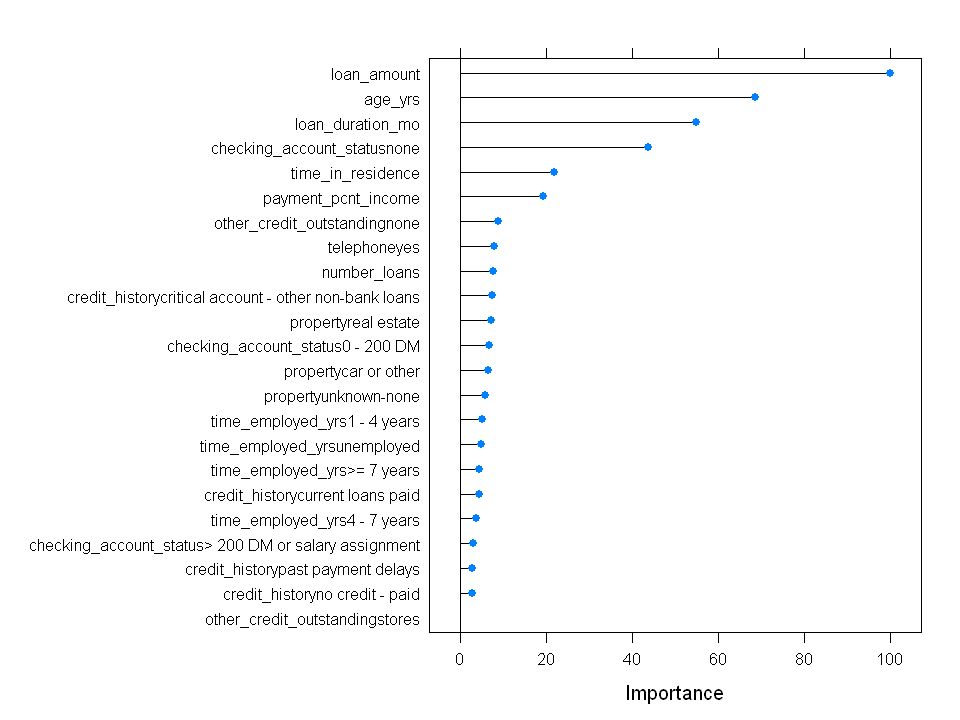

In [44]:
var_imp = varImp(rf_fit)
print(var_imp)
plot(var_imp)

Now, you will run the code in the cell below to perform the outer cross validation of the model. 

In [45]:
score_model = function(df, threshold){
    df$score = ifelse(df$probs[,2] > threshold, 1, 0)
    df
}

binary.eval <- function(df, fold){ 
  # First step is to find the TP, FP, TN, FN cases
  df$conf = ifelse(df$bad_credit == 1 & df$score == 1, 'TP',
                    ifelse(df$bad_credit == 0 & df$score == 1, 'FP',
                           ifelse(df$bad_credit == 0 & df$score == 0, 'TN', 'FN')))
  # Elements of the confusion matrix
  TP = length(df[df$conf == 'TP', 'conf'])
  FP = length(df[df$conf == 'FP', 'conf'])
  TN = length(df[df$conf == 'TN', 'conf'])
  FN = length(df[df$conf == 'FN', 'conf'])
  
  ## Confusion matrix as data frame
  out = data.frame(Negative = c(TN, FN), Positive = c(FP, TP))
  row.names(out) = c('TrueNeg', 'TruePos')
    
  # Compute AUC with ROCR package
  pred_obj = prediction(df$probs[,2], df$bad_credit)
  AUC = performance(pred_obj,"auc")@y.values[[1]]  
  
  # Compute and print metrics
  P = TP/(TP + FP)
  R = TP/(TP + FN)  
  F1 = 2*P*R/(P+R) 
  data.frame = data.frame(fold = as.character(fold),
                          accuracy = (TP + TN)/(TP + TN + FP + FN),
                          precision = P,
                          recall = R,
                          F1 = F1,
                          AUC = AUC)
 }


Create_Folds = function(df, folds){
    ## Create a vector of the fold assignments
    nrows = nrow(df)
    ncount = nrows/folds
    ## Concatenate vectors of fold number
    fold = rep(1, ncount)
    for(i in seq(2, folds, by = 1)){
        fold = c(fold, rep(i, ncount))
    }
    fold
}

Fit_Mod = function(training, test){
    set.seed(5566)
    rf_mod = randomForest(factor(bad_credit) ~ ., data = training, mtry = 10,
                         classwt = c(0.9, 0.1))
    test$probs = predict(rf_mod, newdata = test, type = 'prob')
    test = score_model(test, 0.5)
    test
}

Cross_Validate_Mod = function(df, folds){
    ## Create a vector of the fold assignments
    fold = Create_Folds(df, folds)
    
    ## Randomly shuffle the rows of the data frame
    shuffle = sample(seq(1, nrow(df), by = 1))
    df = df[shuffle,]
    
    ## Loop over number of folds to fit and evaluate the model
    training = df[fold != 1,]
    test = df[fold == 1, ]
    test = Fit_Mod(training, test)
    evals = binary.eval(test, 1)
    for(i in seq(2, folds, by = 1)){
        training = df[fold != i,]
        test = df[fold == i, ]
        test = Fit_Mod(training, test)
        evals = rbind(evals, binary.eval(test, i))
    }
    
    ## Compute some summary statistics and append to the data rame
    evals = rbind(evals, data.frame(fold = 'Mean',
                          accuracy = mean(evals[,2]),
                          precision = mean(evals[,3]),
                          recall = mean(evals[,4]),
                          F1 = mean(evals[,5]),
                          AUC = mean(evals[,6])))
    
    evals = rbind(evals, data.frame(fold = 'std',
                          accuracy = sd(evals[,2]),
                          precision = sd(evals[,3]),
                          recall = sd(evals[,4]),
                          F1 = sd(evals[,5]),
                          AUC = sd(evals[,6])))
    evals
}

Cross_Validate_Mod(credit_reduced, 10)

fold,accuracy,precision,recall,F1,AUC
1,0.79629630,0.7407407,0.57142857,0.64516129,0.79549902
2,0.76767677,0.6071429,0.58620690,0.59649123,0.79039409
3,0.70707071,0.4516129,0.53846154,0.49122807,0.74209694
4,0.70707071,0.6428571,0.48648649,0.55384615,0.72624237
5,0.73737374,0.5000000,0.50000000,0.50000000,0.75974710
6,0.68686869,0.4482759,0.46428571,0.45614035,0.75125755
7,0.71717172,0.5172414,0.51724138,0.51724138,0.80073892
8,0.76767677,0.6400000,0.53333333,0.58181818,0.80265700
9,0.75757576,0.6521739,0.48387097,0.55555556,0.78581594
10,0.72727273,0.5454545,0.41379310,0.47058824,0.68891626


Examine these results. Notice that the standard deviation of the mean of the AUC is more than an order of magnitude smaller than the mean. This indicates that this model is likely to generalize well. 

Now, you will build and test a model using the estimated optimal hyperparameters. As a first step, execute the code in the cell below to create training and testing dataset.

In [ ]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
x_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

The code in the cell below defines a random forest model object using the estimated optimal model hyperparameters and then fits the model to the training data. Execute this code.

In [ ]:
nr.seed(1115)
rf_mod = RandomForestClassifier(n_estimators=40, class_weight = "balanced", max_features = 10, min_samples_leaf = 10) 
rf_mod.fit(x_train, y_train)

As expected, the hyperparemeters of the random forest model object reflect those specified. 

The code in the cell below scores and prints evaluation metrics for the model, using the test data subset. 

Execute this code, examine the results, and answer **Question 4** on the course page. 

In [ ]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('True positive    %6d' % conf[0,0] + '          %5d' % conf[0,1])
    print('True negative    %6d' % conf[1,0] + '          %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, scores))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('             Positive   Negative')
    print('Num case    %0.2f' % metrics[3][0] + '       %0.2f' % metrics[3][1])
    print('Precision   %0.2f' % metrics[0][0] + '          %0.2f' % metrics[0][1])
    print('Recall      %0.2f' % metrics[1][0] + '          %0.2f' % metrics[1][1])
    print('F1          %0.2f' % metrics[2][0] + '          %0.2f' % metrics[2][1])

scores = rf_mod.predict(x_test)
print_metrics(y_test, scores)     

Overall, these performance metrics look quite good. A large majority of negative (bad credit) cases are identified at the expense of significant false positives. The reported AUC is within a standard deviation of the figure obtained with cross validation indicating that the model is generalizing well. 

## Summary

In this lab you have accomplished the following:
1. Used a random forest model to classify the cases of the iris data. A model with more trees had marginally lower error rates, but likely not significantly different.
2. Applied feature importance was used for feature selection with the iris data. The model created and evaluated with the reduced feature set had essentially the same performance as the model with more features.  
2. Used 10 fold to find estimated optimal hyperparameters for a random forest model to classify credit risk cases. The model appears to generalize well.  